# Output analysis

In [1]:
# Importing external packages

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
# Importing model scripts, by first adding the main folder path

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.model_nile import ModelNile
from experimentation.data_generation import generate_input_data
import plotter

ModuleNotFoundError: No module named 'model_classes'

In [2]:
# Change the font type of matplotlib figures to make it match with the report

import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

Let's read the policy and objective value dataframes:

In [3]:
policies = pd.read_csv("merged_dvs.csv")
objectives = pd.read_csv("merged_objectives.csv")

In [4]:
objectives

,Egypt_irr_def,HAD_min_level,Sudan_irr_def,Ethiopia_hydroenergy
0,3.169425,178.101013,0.0,13.520777
1,4.394575,177.009079,0.0,14.200665
2,0.890999,174.851746,0.0,13.913525
3,1.268295,175.973740,0.0,13.901584
4,2.951919,178.100632,0.0,13.404197
...,...,...,...,...
281,0.899015,176.846756,0.0,13.377584
282,0.675063,176.555389,0.0,13.234435
283,2.761871,177.238708,0.0,14.000350
284,1.138742,176.993881,0.0,13.507268


In [5]:
objectives.describe()

,Egypt_irr_def,HAD_min_level,Sudan_irr_def,Ethiopia_hydroenergy
count,286.000000,286.000000,286.000000,286.000000
mean,1.616235,175.853848,0.000010,13.748886
std,1.123866,1.932329,0.000059,0.358364
min,0.091550,168.484070,0.000000,12.587623
25%,0.684151,174.977646,0.000000,13.508258
50%,1.356686,176.425880,0.000000,13.813583
75%,2.394352,177.271919,0.000000,14.021030
max,5.062732,178.119156,0.000694,14.212899


In [6]:
# objectives = objectives.drop(columns=["sudan_90"])

Query the policies which yield best performance with respect to each objective:

In [7]:
best_obj_indices = dict()
directions = ["min", "max", "min", "max"]

for i, obj in enumerate(objectives):
    if directions[i] == "min":
        indexes = objectives.loc[objectives[obj] == objectives[obj].min(), :].index
    elif directions[i] == "max":
        indexes = objectives.loc[objectives[obj] == objectives[obj].max(), :].index
    else:
        print("issue with directions!")

    best_obj_indices[obj] = indexes

In [8]:
best_obj_indices

{'Egypt_irr_def': Int64Index([115], dtype='int64'),
 'HAD_min_level': Int64Index([119], dtype='int64'),
 'Sudan_irr_def': Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             275, 276, 278, 279, 280, 281, 282, 283, 284, 285],
            dtype='int64', length=270),
 'Ethiopia_hydroenergy': Int64Index([58], dtype='int64')}

In [9]:
best_egypt_irr = policies.loc[115]
best_egypt_low_had = policies.loc[119]
best_ethiopia = policies.loc[58]

Before redoing the simulation with found policies, let's do some objectives visualization:

## Parallel Coordinates Plot

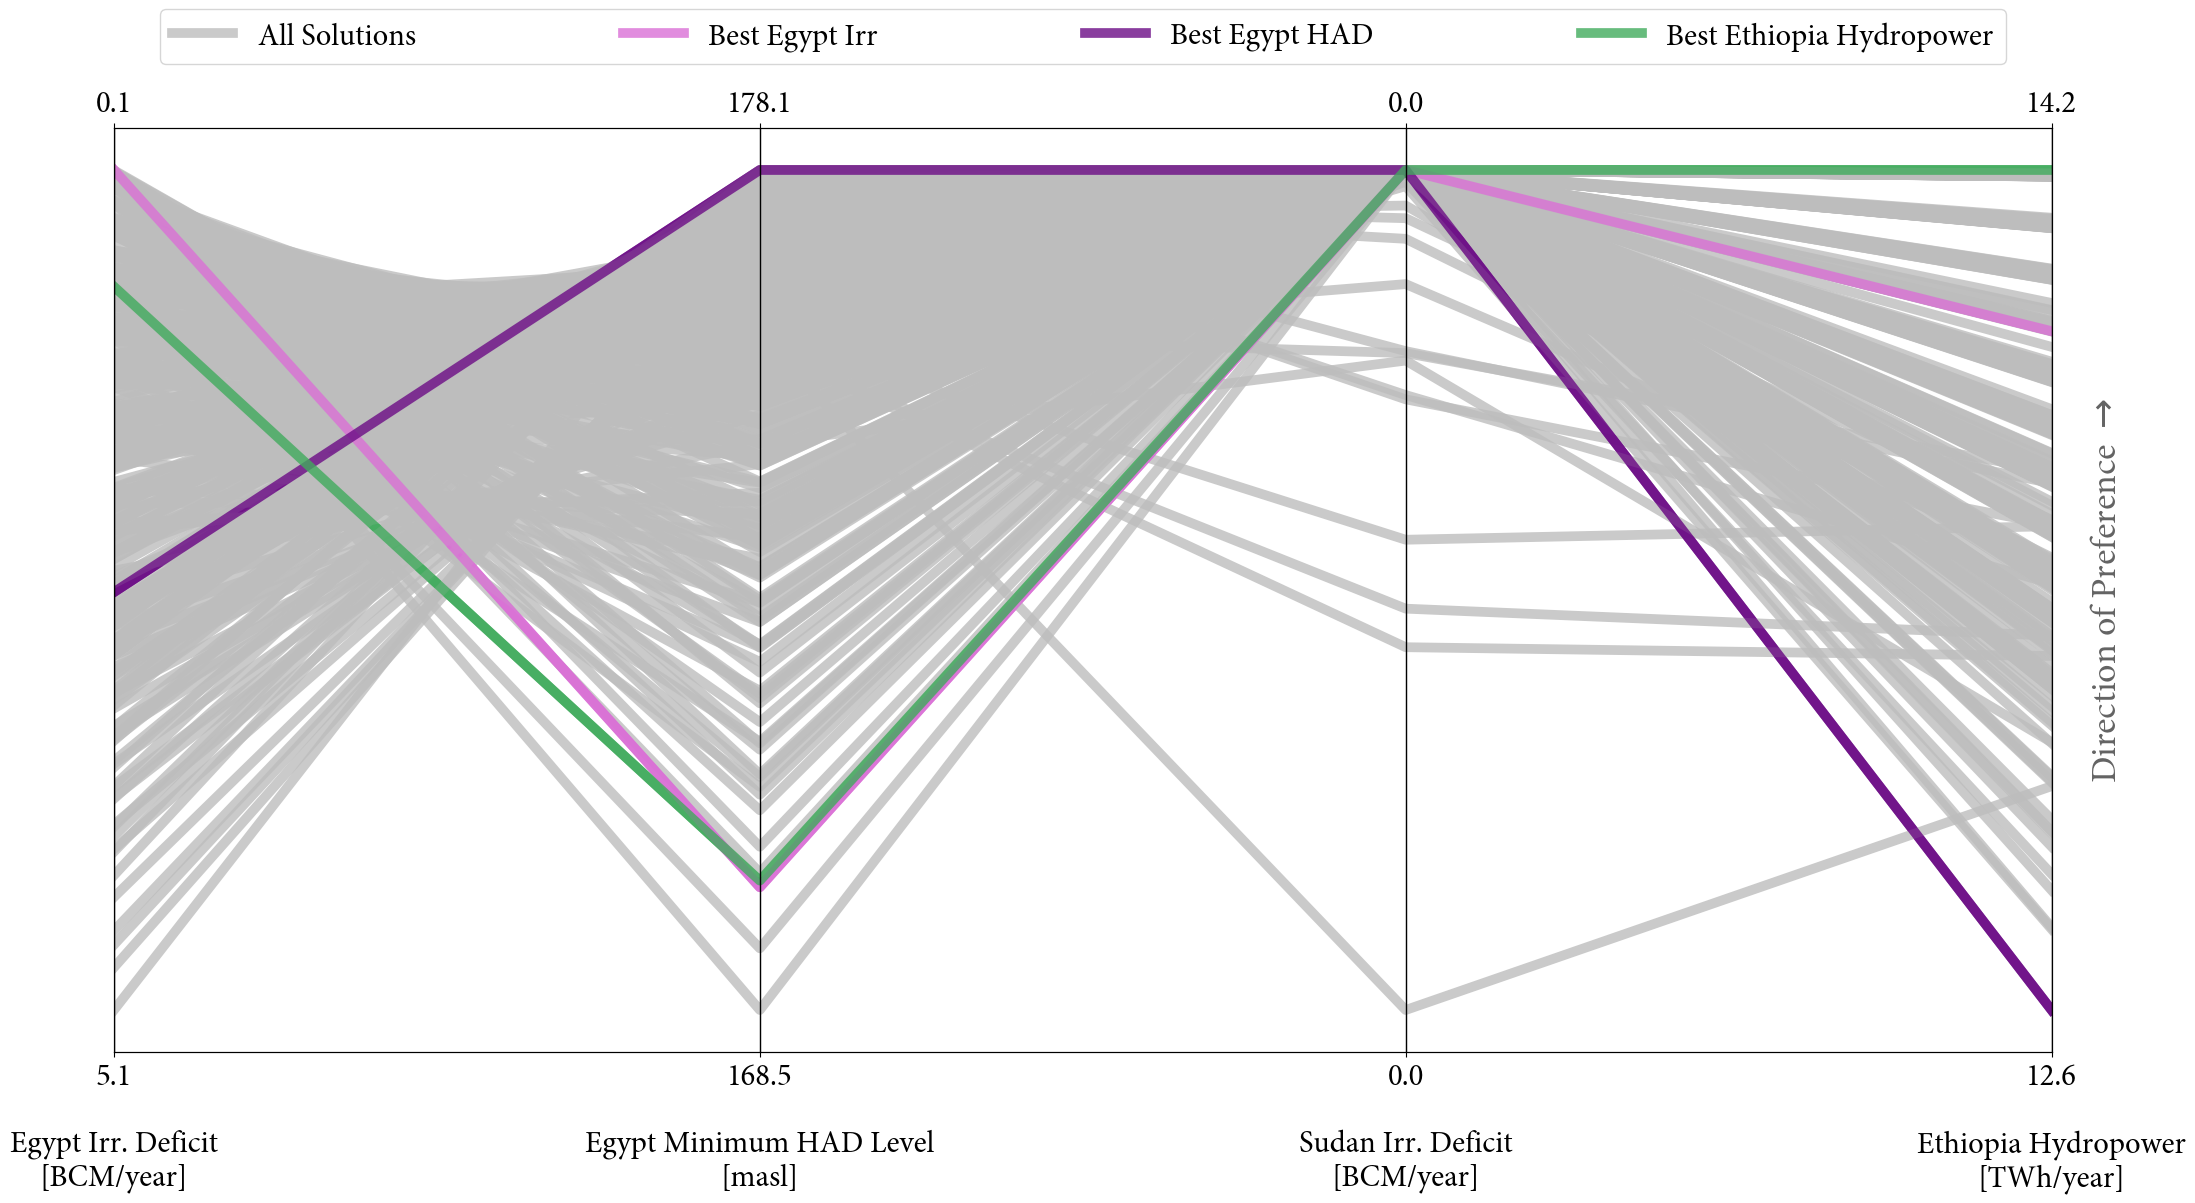

In [10]:
from plotter import parallel_plots_many_policies

parallel_plots_many_policies(
    objectives,
    solution_indices=[115, 119, 58],
    solution_names=[
        "Best Egypt Irr",
        "Best Egypt HAD Level",
        "Best Ethiopia Hydropower",
    ],
)
plt.show()

In [11]:
def normalize_objs(df, directions):
    desirability_couples = list()
    working_df = df.copy()
    for i, col in enumerate(df.columns):
        if directions[i] == "min":
            best, worst = df[col].min(), df[col].max()
        elif directions[i] == "max":
            best, worst = df[col].max(), df[col].min()
        desirability_couples.append((worst, best))
        working_df[col] = (df[col] - worst) / (best - worst)

    return working_df, desirability_couples

Objective values are normalised such that the most desirable value becomes 1 whilst the least desirable becomes 0. On top of the normalised objectives dataframe, we can find some compromise solutions and include them into the color-coded policy set.

In [12]:
norm_df, desire_couples = normalize_objs(objectives, ["min", "max", "min", "max"])

In [13]:
def find_percentile_compromise_solutions(objectives_norm_df, percentile):
    # Given a threshold percentage and normalised objectives data frame,
    # returns the indices which performs above the threshold percentage
    # for all objectives
    index_lists = []
    for col in objectives_norm_df.columns:
        threshold = np.percentile(objectives_norm_df[col], percentile)
        index_lists.append(
            objectives_norm_df.loc[objectives_norm_df[col] >= threshold, :].index
        )

    common_indices = []
    for i in objectives_norm_df.index:
        counter = 0
        for check_list in index_lists:
            if i not in check_list:
                break
            counter += 1
        if counter == len(index_lists):
            common_indices.append(i)

    return common_indices

In [14]:
def find_threshold_compromise_solutions(objectives_norm_df, threshold):
    # Given a threshold value [0-1] and normalised objectives data frame,
    # returns the indices which performs above the threshold value
    # for all objectives
    index_lists = []
    for col in objectives_norm_df.columns:
        index_lists.append(
            objectives_norm_df.loc[objectives_norm_df[col] >= threshold, :].index
        )

    common_indices = []
    for i in objectives_norm_df.index:
        counter = 0
        for check_list in index_lists:
            if i not in check_list:
                break
            counter += 1
        if counter == len(index_lists):
            common_indices.append(i)

    return common_indices

In [19]:
find_percentile_compromise_solutions(norm_df, 48)

[159]

In [25]:
find_threshold_compromise_solutions(norm_df, 0.76)

[3]

Now, we can add two more solutions into the policy set for further analysis:

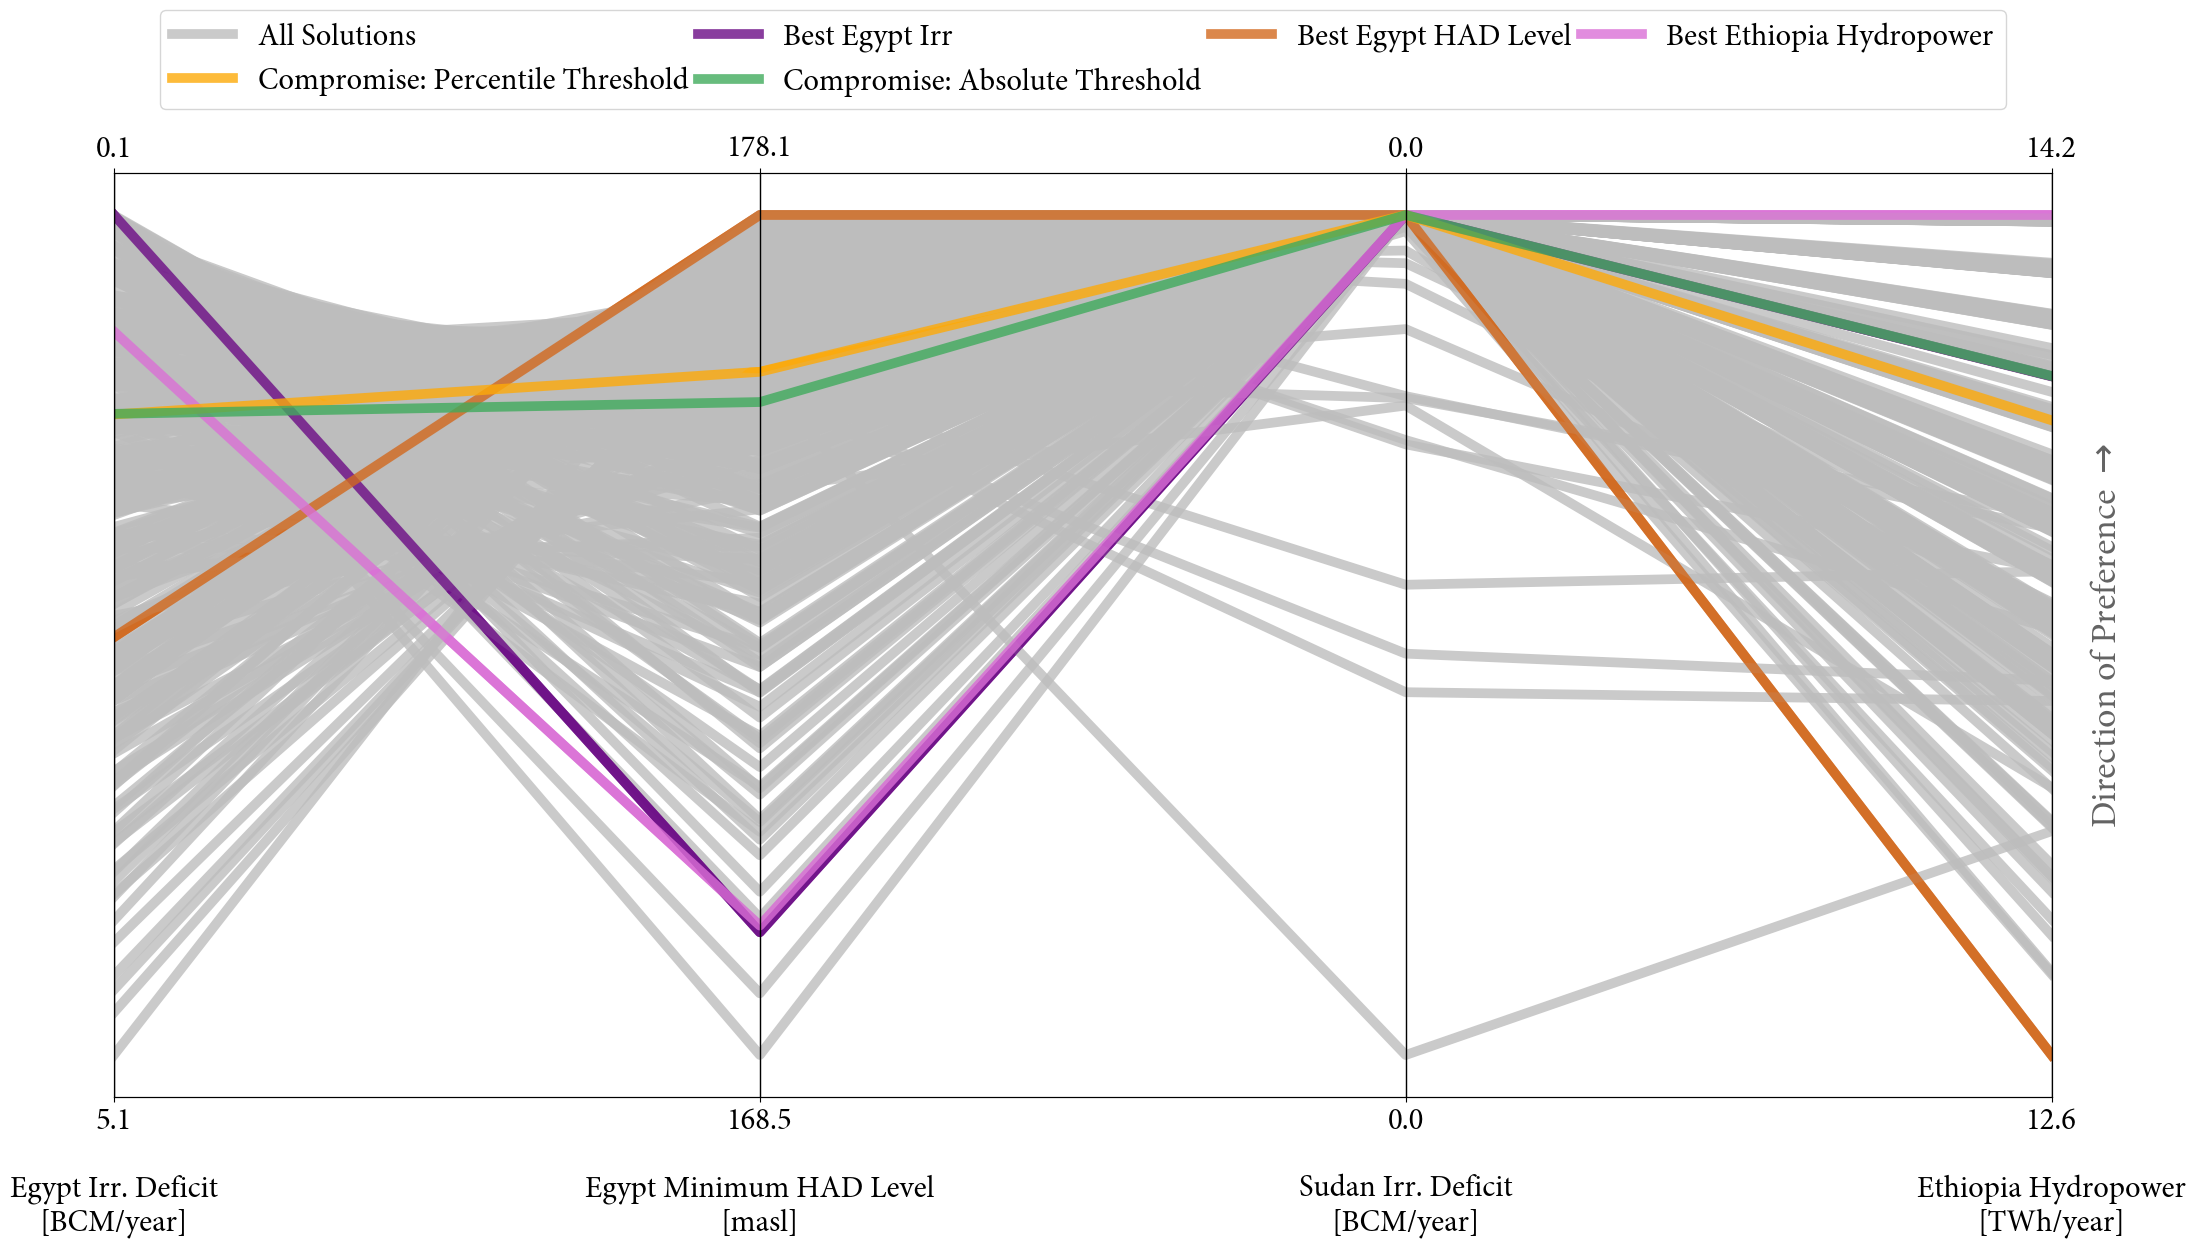

In [27]:
import importlib
import plotter

importlib.reload(plotter)

solution_indices = [115, 119, 58, 159, 3]
solution_names = [
    "Best Egypt Irr",
    "Best Egypt HAD Level",
    "Best Ethiopia Hydropower",
    "Compromise: Percentile Threshold",
    "Compromise: Absolute Threshold",
]

plotter.parallel_plots_many_policies(
    objectives,
    solution_indices=solution_indices,
    solution_names=solution_names,
)

# plt.savefig("../plots/baseline_optimization/parallel_plots.svg", bbox_inches="tight")
plt.show()

For the following stage of open exploration/scenario discovery, we save the six exemplary policies from above analysis:

In [ ]:
policies_for_exploration = policies.loc[[271, 328, 265, 86, 165, 248], :]
policies_for_exploration["name"] = [
    "best_egypt_aggregate",
    "best_egypt_90",
    "best_egypt_HAD",
    "best_ethiopia",
    "compromise_percentile",
    "compromise_threshold",
]
policies_for_exploration

In [ ]:
policies_for_exploration.to_csv("../outputs/policies_exploration.csv", index=False)

## Pair plot of Objective Values

Now, let's show the pairplot of all objectives across the set of solutions found by the optimisation:

In [ ]:
# names_display = [
#     "Egypt Irr. Deficit",
#     "Egypt 90$^{th}$ Irr. Deficit",
#     "Egypt Low HAD",
#     "Sudan Irr. Deficit",
#     "Sudan 90$^{th}$ Irr. Deficit",
#     "Ethiopia Hydropower",
# ]
# norm_df_names = norm_df.copy()
# norm_df_names.columns = names_display
# sns.pairplot(
#     norm_df_names,
#     corner=True,
#     diag_kind="kde",
#     kind="reg",
#     plot_kws={"line_kws": {"color": "red"}},
# )
# plt.show()

## System Behaviour under Selected Policies

Let's first create and run a separate model under every one of the policies and store them in a dict. Then, bring the plotter class for visuals.

In [ ]:
solution_indices = [271, 328, 265, 86, 165, 248]
solutions = [policies.loc[i] for i in solution_indices]
solution_names = [
    "Best Egypt Irr",
    "Best Egypt 90$^{th}$",
    "Best Egypt HAD",
    "Best Ethiopia Hydropower",
    "Compromise: Percentile Threshold",
    "Compromise: Absolute Threshold",
]
running_models = dict()
for i, sol_name in tqdm(enumerate(solution_names)):
    new_model = ModelNile()
    new_model = generate_input_data(new_model)
    new_model.evaluate(solutions[i])
    running_models[sol_name] = new_model

In [ ]:
running_models["Best Egypt Irr"].object_by_name("HAD").release_vector

In [ ]:
import importlib

importlib.reload(plotter)

for key, value in running_models.items():
    print("----------------")
    print(key)
    print("----------------")
    my_plotter = plotter.HydroModelPlotter(value)

    for dam in ["GERD", "HAD"]:
        my_plotter.plot_condensed_release_versus_inflow(dam)
        plt.savefig(
            f"../plots/baseline_optimization/{dam}/release_vs_inflow_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()

        my_plotter.plot_condensed_level(dam)
        plt.savefig(
            f"../plots/baseline_optimization/{dam}/condensed_level_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()

        my_plotter.plot_level_with_limits(dam)
        plt.savefig(
            f"../plots/baseline_optimization/{dam}/level_with_limits_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()

    for district in ["Egypt", "Gezira"]:
        my_plotter.plot_received_vs_demand_for_district_raw_condensed(district)
        plt.savefig(
            f"../plots/baseline_optimization/{district}/received_vs_demand_{key}_policy.svg",
        )  # bbox_inches="tight")
        plt.show()